In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap


import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [7]:
# Training the model from scratch
num_epochs=200
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-malimg-resnet50-avgpool-Adam-200epochs-fromscratch.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    base_model = ResNet50(weights=None, input_shape=image_shape, include_top=False)
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D(name='global_avg_pool'))
    model.add(Dense(num_classes, activation='softmax', name='predictions'))
    
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 8394 samples, validate on 945 samples
Epoch 1/200
8394/8394 [==============================] - 97s - loss: 0.9268 - acc: 0.8126 - val_loss: 4.1032 - val_acc: 0.3439
Epoch 2/200
8394/8394 [==============================] - 88s - loss: 0.7727 - acc: 0.8767 - val_loss: 14.3335 - val_acc: 0.0847
Epoch 3/200
8394/8394 [==============================] - 88s - loss: 0.2530 - acc: 0.9666 - val_loss: 2.4055 - val_acc: 0.7101
Epoch 4/200
8394/8394 [==============================] - 89s - loss: 0.2451 - acc: 0.9699 - val_loss: 0.5168 - val_acc: 0.8751
Epoch 5/200
8394/8394 [==============================] - 89s - loss: 0.2205 - acc: 0.9766 - val_loss: 0.2853 - val_acc: 0.9661
Epoch 6/200
8394/8394 [==============================] - 88s - loss: 0.2209 - acc: 0.9695 - val_loss: 13.8328 - val_acc: 0.0529
Epoch 7/200
8394/8394 [==============================] - 87s - loss: 0.2728 - acc: 0.9607 - val_loss: 0.3361 - val_acc: 0.9513
Epoch 8/200
8394/8394 [==============================] - 86s -

8394/8394 [==============================] - 86s - loss: 0.0143 - acc: 0.9951 - val_loss: 4.0551 - val_acc: 0.5450
Epoch 65/200
8394/8394 [==============================] - 87s - loss: 0.0309 - acc: 0.9906 - val_loss: 2.3766 - val_acc: 0.7481
Epoch 66/200
8394/8394 [==============================] - 86s - loss: 0.0364 - acc: 0.9877 - val_loss: 3.7003 - val_acc: 0.6413
Epoch 67/200
8394/8394 [==============================] - 87s - loss: 0.0167 - acc: 0.9933 - val_loss: 0.8573 - val_acc: 0.8349
Epoch 68/200
8394/8394 [==============================] - 87s - loss: 0.0067 - acc: 0.9980 - val_loss: 0.0832 - val_acc: 0.9831
Epoch 69/200
8394/8394 [==============================] - 87s - loss: 0.0383 - acc: 0.9901 - val_loss: 0.7392 - val_acc: 0.8265
Epoch 70/200
8394/8394 [==============================] - 86s - loss: 0.0120 - acc: 0.9958 - val_loss: 0.0499 - val_acc: 0.9862
Epoch 71/200
8394/8394 [==============================] - 86s - loss: 0.0114 - acc: 0.9963 - val_loss: 0.0891 - val_a

8394/8394 [==============================] - 89s - loss: 6.0521e-05 - acc: 1.0000 - val_loss: 0.0701 - val_acc: 0.9862
Epoch 128/200
8394/8394 [==============================] - 89s - loss: 8.3040e-05 - acc: 1.0000 - val_loss: 0.0725 - val_acc: 0.9873
Epoch 129/200
8394/8394 [==============================] - 88s - loss: 5.0145e-05 - acc: 1.0000 - val_loss: 0.0718 - val_acc: 0.9862
Epoch 130/200
8394/8394 [==============================] - 88s - loss: 3.8973e-05 - acc: 1.0000 - val_loss: 0.0719 - val_acc: 0.9862
Epoch 131/200
8394/8394 [==============================] - 88s - loss: 4.2726e-05 - acc: 1.0000 - val_loss: 0.0776 - val_acc: 0.9873
Epoch 132/200
8394/8394 [==============================] - 87s - loss: 3.9484e-05 - acc: 1.0000 - val_loss: 0.0734 - val_acc: 0.9862
Epoch 133/200
8394/8394 [==============================] - 85s - loss: 5.1852e-05 - acc: 1.0000 - val_loss: 0.0754 - val_acc: 0.9862
Epoch 134/200
8394/8394 [==============================] - 86s - loss: 5.3782e-05 -

8394/8394 [==============================] - 86s - loss: 8.2804e-04 - acc: 0.9996 - val_loss: 0.0919 - val_acc: 0.9873
Epoch 190/200
8394/8394 [==============================] - 86s - loss: 2.1147e-04 - acc: 1.0000 - val_loss: 0.0796 - val_acc: 0.9884
Epoch 191/200
8394/8394 [==============================] - 88s - loss: 2.7023e-04 - acc: 0.9999 - val_loss: 0.1423 - val_acc: 0.9820
Epoch 192/200
8394/8394 [==============================] - 88s - loss: 0.0081 - acc: 0.9981 - val_loss: 0.1121 - val_acc: 0.9746
Epoch 193/200
8394/8394 [==============================] - 88s - loss: 0.0035 - acc: 0.9992 - val_loss: 3.7033 - val_acc: 0.6593
Epoch 194/200
8394/8394 [==============================] - 89s - loss: 0.0021 - acc: 0.9995 - val_loss: 0.0829 - val_acc: 0.9841
Epoch 195/200
8394/8394 [==============================] - 86s - loss: 0.0012 - acc: 0.9999 - val_loss: 0.0891 - val_acc: 0.9873
Epoch 196/200
8394/8394 [==============================] - 87s - loss: 9.4616e-05 - acc: 1.0000 - v

8397/8397 [==============================] - 87s - loss: 0.0865 - acc: 0.9752 - val_loss: 3.5473 - val_acc: 0.3790
Epoch 52/200
8397/8397 [==============================] - 87s - loss: 0.0506 - acc: 0.9852 - val_loss: 0.1128 - val_acc: 0.9756
Epoch 53/200
8397/8397 [==============================] - 86s - loss: 0.0440 - acc: 0.9871 - val_loss: 0.1270 - val_acc: 0.9671
Epoch 54/200
8397/8397 [==============================] - 87s - loss: 0.0618 - acc: 0.9815 - val_loss: 7.7890 - val_acc: 0.3100
Epoch 55/200
8397/8397 [==============================] - 87s - loss: 0.1104 - acc: 0.9703 - val_loss: 1.8442 - val_acc: 0.8110
Epoch 56/200
8397/8397 [==============================] - 87s - loss: 0.1021 - acc: 0.9702 - val_loss: 0.2229 - val_acc: 0.9448
Epoch 57/200
8397/8397 [==============================] - 86s - loss: 0.0523 - acc: 0.9836 - val_loss: 0.0651 - val_acc: 0.9766
Epoch 58/200
8397/8397 [==============================] - 87s - loss: 0.0516 - acc: 0.9834 - val_loss: 0.0652 - val_a

8397/8397 [==============================] - 86s - loss: 4.7340e-05 - acc: 1.0000 - val_loss: 0.0429 - val_acc: 0.9915
Epoch 115/200
8397/8397 [==============================] - 85s - loss: 2.9350e-05 - acc: 1.0000 - val_loss: 0.0416 - val_acc: 0.9926
Epoch 116/200
8397/8397 [==============================] - 84s - loss: 1.9864e-05 - acc: 1.0000 - val_loss: 0.0423 - val_acc: 0.9915
Epoch 117/200
8397/8397 [==============================] - 86s - loss: 2.3035e-05 - acc: 1.0000 - val_loss: 0.0424 - val_acc: 0.9915
Epoch 118/200
8397/8397 [==============================] - 86s - loss: 2.0690e-05 - acc: 1.0000 - val_loss: 0.0412 - val_acc: 0.9915
Epoch 119/200
8397/8397 [==============================] - 87s - loss: 2.3855e-05 - acc: 1.0000 - val_loss: 0.0415 - val_acc: 0.9915
Epoch 120/200
8397/8397 [==============================] - 87s - loss: 2.1485e-05 - acc: 1.0000 - val_loss: 0.0412 - val_acc: 0.9915
Epoch 121/200
8397/8397 [==============================] - 85s - loss: 2.9828e-05 -

8397/8397 [==============================] - 85s - loss: 3.2720e-04 - acc: 1.0000 - val_loss: 0.0351 - val_acc: 0.9926
Epoch 177/200
8397/8397 [==============================] - 87s - loss: 2.8701e-04 - acc: 1.0000 - val_loss: 0.0448 - val_acc: 0.9915
Epoch 178/200
8397/8397 [==============================] - 86s - loss: 1.5862e-04 - acc: 1.0000 - val_loss: 0.0408 - val_acc: 0.9926
Epoch 179/200
8397/8397 [==============================] - 87s - loss: 7.1644e-05 - acc: 1.0000 - val_loss: 0.0415 - val_acc: 0.9926
Epoch 180/200
8397/8397 [==============================] - 86s - loss: 5.0507e-05 - acc: 1.0000 - val_loss: 0.0413 - val_acc: 0.9926
Epoch 181/200
8397/8397 [==============================] - 84s - loss: 9.0661e-05 - acc: 1.0000 - val_loss: 0.0422 - val_acc: 0.9947
Epoch 182/200
8397/8397 [==============================] - 84s - loss: 7.5683e-05 - acc: 1.0000 - val_loss: 0.0394 - val_acc: 0.9936
Epoch 183/200
8397/8397 [==============================] - 87s - loss: 5.3522e-05 -

8401/8401 [==============================] - 85s - loss: 0.0089 - acc: 0.9976 - val_loss: 0.0814 - val_acc: 0.9872
Epoch 39/200
8401/8401 [==============================] - 84s - loss: 0.0073 - acc: 0.9981 - val_loss: 0.0656 - val_acc: 0.9883
Epoch 40/200
8401/8401 [==============================] - 86s - loss: 0.0043 - acc: 0.9988 - val_loss: 0.0602 - val_acc: 0.9883
Epoch 41/200
8401/8401 [==============================] - 85s - loss: 0.0023 - acc: 0.9999 - val_loss: 0.0601 - val_acc: 0.9925
Epoch 42/200
8401/8401 [==============================] - 85s - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0662 - val_acc: 0.9904
Epoch 43/200
8401/8401 [==============================] - 85s - loss: 0.0404 - acc: 0.9870 - val_loss: 0.6867 - val_acc: 0.8731
Epoch 44/200
8401/8401 [==============================] - 85s - loss: 0.0374 - acc: 0.9894 - val_loss: 0.0933 - val_acc: 0.9744
Epoch 45/200
8401/8401 [==============================] - 85s - loss: 0.0229 - acc: 0.9936 - val_loss: 0.0994 - val_a

8401/8401 [==============================] - 86s - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0595 - val_acc: 0.9915
Epoch 103/200
8401/8401 [==============================] - 86s - loss: 4.2314e-04 - acc: 1.0000 - val_loss: 0.0600 - val_acc: 0.9925
Epoch 104/200
8401/8401 [==============================] - 86s - loss: 2.2279e-04 - acc: 1.0000 - val_loss: 0.0587 - val_acc: 0.9936
Epoch 105/200
8401/8401 [==============================] - 86s - loss: 8.1905e-04 - acc: 0.9996 - val_loss: 0.0706 - val_acc: 0.9893
Epoch 106/200
8401/8401 [==============================] - 85s - loss: 3.6940e-04 - acc: 1.0000 - val_loss: 0.0629 - val_acc: 0.9915
Epoch 107/200
8401/8401 [==============================] - 84s - loss: 1.6636e-04 - acc: 1.0000 - val_loss: 0.0628 - val_acc: 0.9936
Epoch 108/200
8401/8401 [==============================] - 85s - loss: 9.4929e-05 - acc: 1.0000 - val_loss: 0.0625 - val_acc: 0.9936
Epoch 109/200
8401/8401 [==============================] - 84s - loss: 1.2110e-04 - acc

8401/8401 [==============================] - 85s - loss: 1.6550e-05 - acc: 1.0000 - val_loss: 0.0666 - val_acc: 0.9915
Epoch 165/200
8401/8401 [==============================] - 85s - loss: 0.0293 - acc: 0.9911 - val_loss: 0.5791 - val_acc: 0.9051
Epoch 166/200
8401/8401 [==============================] - 85s - loss: 0.0481 - acc: 0.9906 - val_loss: 0.1673 - val_acc: 0.9680
Epoch 167/200
8401/8401 [==============================] - 84s - loss: 0.0065 - acc: 0.9979 - val_loss: 0.0795 - val_acc: 0.9851
Epoch 168/200
8401/8401 [==============================] - 85s - loss: 0.0057 - acc: 0.9986 - val_loss: 0.0747 - val_acc: 0.9861
Epoch 169/200
8401/8401 [==============================] - 84s - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0664 - val_acc: 0.9904
Epoch 170/200
8401/8401 [==============================] - 86s - loss: 2.9060e-04 - acc: 1.0000 - val_loss: 0.0610 - val_acc: 0.9883
Epoch 171/200
8401/8401 [==============================] - 87s - loss: 1.3538e-04 - acc: 1.0000 - val_l

8403/8403 [==============================] - 84s - loss: 0.4448 - acc: 0.9691 - val_loss: 0.4435 - val_acc: 0.9658
Epoch 27/200
8403/8403 [==============================] - 84s - loss: 0.4353 - acc: 0.9716 - val_loss: 0.4414 - val_acc: 0.9690
Epoch 28/200
8403/8403 [==============================] - 84s - loss: 0.4478 - acc: 0.9682 - val_loss: 0.4865 - val_acc: 0.9509
Epoch 29/200
8403/8403 [==============================] - 84s - loss: 0.4417 - acc: 0.9693 - val_loss: 0.5867 - val_acc: 0.9380
Epoch 30/200
8403/8403 [==============================] - 84s - loss: 0.4977 - acc: 0.9550 - val_loss: 4.8050 - val_acc: 0.6261
Epoch 31/200
8403/8403 [==============================] - 84s - loss: 0.4580 - acc: 0.9647 - val_loss: 0.4660 - val_acc: 0.9605
Epoch 32/200
8403/8403 [==============================] - 84s - loss: 0.4701 - acc: 0.9606 - val_loss: 0.4509 - val_acc: 0.9669
Epoch 33/200
8403/8403 [==============================] - 84s - loss: 0.4492 - acc: 0.9683 - val_loss: 2.8131 - val_a

8403/8403 [==============================] - 84s - loss: 1.8159 - acc: 0.8856 - val_loss: 1.8469 - val_acc: 0.8771
Epoch 91/200
8403/8403 [==============================] - 84s - loss: 1.8188 - acc: 0.8846 - val_loss: 1.8345 - val_acc: 0.8814
Epoch 92/200
8403/8403 [==============================] - 84s - loss: 1.8149 - acc: 0.8858 - val_loss: 1.8290 - val_acc: 0.8814
Epoch 93/200
8403/8403 [==============================] - 84s - loss: 1.8171 - acc: 0.8852 - val_loss: 7.4222 - val_acc: 0.4679
Epoch 94/200
8403/8403 [==============================] - 84s - loss: 1.8117 - acc: 0.8868 - val_loss: 1.8407 - val_acc: 0.8835
Epoch 95/200
8403/8403 [==============================] - 84s - loss: 1.8095 - acc: 0.8878 - val_loss: 1.8363 - val_acc: 0.8814
Epoch 96/200
8403/8403 [==============================] - 84s - loss: 1.8150 - acc: 0.8874 - val_loss: 1.8352 - val_acc: 0.8825
Epoch 97/200
8403/8403 [==============================] - 84s - loss: 1.8108 - acc: 0.8871 - val_loss: 1.8382 - val_a

8403/8403 [==============================] - 84s - loss: 1.5638 - acc: 0.9029 - val_loss: 1.6011 - val_acc: 0.8985
Epoch 154/200
8403/8403 [==============================] - 84s - loss: 1.6347 - acc: 0.8912 - val_loss: 1.6757 - val_acc: 0.8793
Epoch 155/200
8403/8403 [==============================] - 84s - loss: 1.5719 - acc: 0.9004 - val_loss: 1.5878 - val_acc: 0.8964
Epoch 156/200
8403/8403 [==============================] - 84s - loss: 1.5683 - acc: 0.9015 - val_loss: 1.5872 - val_acc: 0.8974
Epoch 157/200
8403/8403 [==============================] - 84s - loss: 1.5646 - acc: 0.9027 - val_loss: 1.5968 - val_acc: 0.8974
Epoch 158/200
8403/8403 [==============================] - 84s - loss: 1.5636 - acc: 0.9030 - val_loss: 1.5987 - val_acc: 0.8985
Epoch 159/200
8403/8403 [==============================] - 85s - loss: 1.6064 - acc: 0.8991 - val_loss: 1.7685 - val_acc: 0.8600
Epoch 160/200
8403/8403 [==============================] - 84s - loss: 1.5722 - acc: 0.9004 - val_loss: 1.6502 

8404/8404 [==============================] - 86s - loss: 0.0157 - acc: 0.9965 - val_loss: 2.1909 - val_acc: 0.7444
Epoch 16/200
8404/8404 [==============================] - 86s - loss: 0.1475 - acc: 0.9623 - val_loss: 11.2623 - val_acc: 0.1925
Epoch 17/200
8404/8404 [==============================] - 86s - loss: 0.1242 - acc: 0.9663 - val_loss: 0.1586 - val_acc: 0.9337
Epoch 18/200
8404/8404 [==============================] - 85s - loss: 0.0662 - acc: 0.9795 - val_loss: 0.0909 - val_acc: 0.9690
Epoch 19/200
8404/8404 [==============================] - 85s - loss: 0.0354 - acc: 0.9888 - val_loss: 0.0415 - val_acc: 0.9829
Epoch 20/200
8404/8404 [==============================] - 85s - loss: 0.0124 - acc: 0.9962 - val_loss: 0.0578 - val_acc: 0.9807
Epoch 21/200
8404/8404 [==============================] - 85s - loss: 0.0170 - acc: 0.9952 - val_loss: 0.0725 - val_acc: 0.9861
Epoch 22/200
8404/8404 [==============================] - 86s - loss: 0.0141 - acc: 0.9954 - val_loss: 2.5304 - val_

8404/8404 [==============================] - 85s - loss: 0.1891 - acc: 0.9858 - val_loss: 0.2216 - val_acc: 0.9786
Epoch 79/200
8404/8404 [==============================] - 85s - loss: 0.1864 - acc: 0.9873 - val_loss: 0.2087 - val_acc: 0.9797
Epoch 80/200
8404/8404 [==============================] - 85s - loss: 0.1931 - acc: 0.9857 - val_loss: 0.4969 - val_acc: 0.9369
Epoch 81/200
8404/8404 [==============================] - 85s - loss: 0.1934 - acc: 0.9847 - val_loss: 0.2360 - val_acc: 0.9775
Epoch 82/200
8404/8404 [==============================] - 85s - loss: 0.1835 - acc: 0.9885 - val_loss: 0.2230 - val_acc: 0.9775
Epoch 83/200
8404/8404 [==============================] - 85s - loss: 0.1825 - acc: 0.9887 - val_loss: 0.2141 - val_acc: 0.9786
Epoch 84/200
8404/8404 [==============================] - 86s - loss: 0.1823 - acc: 0.9887 - val_loss: 0.2143 - val_acc: 0.9786
Epoch 85/200
8404/8404 [==============================] - 85s - loss: 0.1823 - acc: 0.9887 - val_loss: 0.2152 - val_a

8404/8404 [==============================] - 85s - loss: 1.0356e-04 - acc: 1.0000 - val_loss: 0.0563 - val_acc: 0.9893
Epoch 142/200
8404/8404 [==============================] - 84s - loss: 8.6671e-05 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9904
Epoch 143/200
8404/8404 [==============================] - 85s - loss: 9.2941e-05 - acc: 1.0000 - val_loss: 0.0588 - val_acc: 0.9872
Epoch 144/200
8404/8404 [==============================] - 85s - loss: 4.9869e-05 - acc: 1.0000 - val_loss: 0.0595 - val_acc: 0.9893
Epoch 145/200
8404/8404 [==============================] - 85s - loss: 3.4574e-05 - acc: 1.0000 - val_loss: 0.0606 - val_acc: 0.9872
Epoch 146/200
8404/8404 [==============================] - 86s - loss: 2.5885e-05 - acc: 1.0000 - val_loss: 0.0610 - val_acc: 0.9861
Epoch 147/200
8404/8404 [==============================] - 85s - loss: 3.1734e-05 - acc: 1.0000 - val_loss: 0.0620 - val_acc: 0.9882
Epoch 148/200
8404/8404 [==============================] - 86s - loss: 4.0200e-05 -

8404/8404 [==============================] - 84s - loss: 0.1390 - acc: 0.9588 - val_loss: 0.1339 - val_acc: 0.9626
Epoch 4/200
8404/8404 [==============================] - 84s - loss: 0.1069 - acc: 0.9668 - val_loss: 0.3803 - val_acc: 0.8995
Epoch 5/200
8404/8404 [==============================] - 84s - loss: 0.1084 - acc: 0.9680 - val_loss: 4.1012 - val_acc: 0.5722
Epoch 6/200
8404/8404 [==============================] - 84s - loss: 0.0973 - acc: 0.9669 - val_loss: 0.1845 - val_acc: 0.9604
Epoch 7/200
8404/8404 [==============================] - 84s - loss: 0.0330 - acc: 0.9888 - val_loss: 0.0608 - val_acc: 0.9807
Epoch 8/200
8404/8404 [==============================] - 84s - loss: 0.0184 - acc: 0.9939 - val_loss: 0.0821 - val_acc: 0.9754
Epoch 9/200
8404/8404 [==============================] - 84s - loss: 0.0962 - acc: 0.9755 - val_loss: 8.3638 - val_acc: 0.2257
Epoch 10/200
8404/8404 [==============================] - 84s - loss: 0.0882 - acc: 0.9716 - val_loss: 2.9634 - val_acc: 0.

8404/8404 [==============================] - 83s - loss: 0.0057 - acc: 0.9979 - val_loss: 0.0468 - val_acc: 0.9861
Epoch 68/200
8404/8404 [==============================] - 84s - loss: 0.0035 - acc: 0.9989 - val_loss: 0.0460 - val_acc: 0.9914
Epoch 69/200
8404/8404 [==============================] - 84s - loss: 8.2862e-04 - acc: 0.9999 - val_loss: 0.0406 - val_acc: 0.9882
Epoch 70/200
8404/8404 [==============================] - 84s - loss: 2.4436e-04 - acc: 1.0000 - val_loss: 0.0420 - val_acc: 0.9882
Epoch 71/200
8404/8404 [==============================] - 84s - loss: 3.2665e-04 - acc: 1.0000 - val_loss: 0.0442 - val_acc: 0.9914
Epoch 72/200
8404/8404 [==============================] - 84s - loss: 8.9273e-04 - acc: 0.9998 - val_loss: 0.0471 - val_acc: 0.9904
Epoch 73/200
8404/8404 [==============================] - 84s - loss: 1.5052e-04 - acc: 1.0000 - val_loss: 0.0494 - val_acc: 0.9893
Epoch 74/200
8404/8404 [==============================] - 84s - loss: 3.2691e-04 - acc: 1.0000 - 

8404/8404 [==============================] - 84s - loss: 0.0196 - acc: 0.9952 - val_loss: 13.6427 - val_acc: 0.0471
Epoch 130/200
8404/8404 [==============================] - 84s - loss: 0.0574 - acc: 0.9862 - val_loss: 1.3205 - val_acc: 0.7615
Epoch 131/200
8404/8404 [==============================] - 84s - loss: 0.0065 - acc: 0.9977 - val_loss: 0.0417 - val_acc: 0.9893
Epoch 132/200
8404/8404 [==============================] - 84s - loss: 0.0040 - acc: 0.9985 - val_loss: 0.0539 - val_acc: 0.9882
Epoch 133/200
8404/8404 [==============================] - 84s - loss: 0.0023 - acc: 0.9993 - val_loss: 0.0564 - val_acc: 0.9850
Epoch 134/200
8404/8404 [==============================] - 84s - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0453 - val_acc: 0.9882
Epoch 135/200
8404/8404 [==============================] - 84s - loss: 4.2112e-04 - acc: 1.0000 - val_loss: 0.0476 - val_acc: 0.9882
Epoch 136/200
8404/8404 [==============================] - 84s - loss: 1.6125e-04 - acc: 1.0000 - val_loss

8404/8404 [==============================] - 84s - loss: 1.8582e-05 - acc: 1.0000 - val_loss: 0.0578 - val_acc: 0.9893
Epoch 192/200
8404/8404 [==============================] - 84s - loss: 1.5606e-05 - acc: 1.0000 - val_loss: 0.0571 - val_acc: 0.9882
Epoch 193/200
8404/8404 [==============================] - 84s - loss: 1.9186e-05 - acc: 1.0000 - val_loss: 0.0533 - val_acc: 0.9893
Epoch 194/200
8404/8404 [==============================] - 84s - loss: 9.8823e-06 - acc: 1.0000 - val_loss: 0.0552 - val_acc: 0.9882
Epoch 195/200
8404/8404 [==============================] - 84s - loss: 8.7935e-06 - acc: 1.0000 - val_loss: 0.0557 - val_acc: 0.9882
Epoch 196/200
8404/8404 [==============================] - 84s - loss: 1.5715e-05 - acc: 1.0000 - val_loss: 0.0608 - val_acc: 0.9882
Epoch 197/200
8404/8404 [==============================] - 84s - loss: 1.0240e-05 - acc: 1.0000 - val_loss: 0.0594 - val_acc: 0.9882
Epoch 198/200
8404/8404 [==============================] - 84s - loss: 5.7160e-06 -

8408/8408 [==============================] - 84s - loss: 0.0058 - acc: 0.9986 - val_loss: 0.0662 - val_acc: 0.9871
Epoch 54/200
8408/8408 [==============================] - 84s - loss: 0.0021 - acc: 0.9995 - val_loss: 0.0474 - val_acc: 0.9914
Epoch 55/200
8408/8408 [==============================] - 84s - loss: 0.0049 - acc: 0.9986 - val_loss: 0.1849 - val_acc: 0.9474
Epoch 56/200
8408/8408 [==============================] - 84s - loss: 0.0053 - acc: 0.9980 - val_loss: 0.4759 - val_acc: 0.9291
Epoch 57/200
8408/8408 [==============================] - 84s - loss: 0.0020 - acc: 0.9993 - val_loss: 0.0620 - val_acc: 0.9882
Epoch 58/200
8408/8408 [==============================] - 84s - loss: 0.0025 - acc: 0.9990 - val_loss: 0.0575 - val_acc: 0.9893
Epoch 59/200
8408/8408 [==============================] - 85s - loss: 0.0306 - acc: 0.9912 - val_loss: 0.3882 - val_acc: 0.9323
Epoch 60/200
8408/8408 [==============================] - 84s - loss: 0.0357 - acc: 0.9902 - val_loss: 0.2706 - val_a

8408/8408 [==============================] - 84s - loss: 0.0024 - acc: 0.9993 - val_loss: 0.0799 - val_acc: 0.9850
Epoch 117/200
8408/8408 [==============================] - 84s - loss: 0.0078 - acc: 0.9980 - val_loss: 0.0452 - val_acc: 0.9914
Epoch 118/200
8408/8408 [==============================] - 84s - loss: 0.0045 - acc: 0.9982 - val_loss: 0.0425 - val_acc: 0.9936
Epoch 119/200
8408/8408 [==============================] - 84s - loss: 6.7348e-04 - acc: 0.9996 - val_loss: 0.0453 - val_acc: 0.9903
Epoch 120/200
8408/8408 [==============================] - 84s - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0904 - val_acc: 0.9850
Epoch 121/200
8408/8408 [==============================] - 84s - loss: 0.0086 - acc: 0.9977 - val_loss: 0.0527 - val_acc: 0.9914
Epoch 122/200
8408/8408 [==============================] - 85s - loss: 0.0031 - acc: 0.9989 - val_loss: 0.3147 - val_acc: 0.9592
Epoch 123/200
8408/8408 [==============================] - 84s - loss: 0.0034 - acc: 0.9989 - val_loss: 0.1

8408/8408 [==============================] - 84s - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0496 - val_acc: 0.9914
Epoch 180/200
8408/8408 [==============================] - 84s - loss: 1.3517 - acc: 0.9151 - val_loss: 1.4401 - val_acc: 0.9012
Epoch 181/200
8408/8408 [==============================] - 84s - loss: 1.2440 - acc: 0.9166 - val_loss: 0.9338 - val_acc: 0.8958
Epoch 182/200
8408/8408 [==============================] - 84s - loss: 0.0449 - acc: 0.9864 - val_loss: 0.0945 - val_acc: 0.9785
Epoch 183/200
8408/8408 [==============================] - 84s - loss: 0.0385 - acc: 0.9885 - val_loss: 0.0929 - val_acc: 0.9796
Epoch 184/200
8408/8408 [==============================] - 84s - loss: 0.0362 - acc: 0.9886 - val_loss: 0.0997 - val_acc: 0.9796
Epoch 185/200
8408/8408 [==============================] - 84s - loss: 0.0346 - acc: 0.9886 - val_loss: 0.0908 - val_acc: 0.9785
Epoch 186/200
8408/8408 [==============================] - 84s - loss: 0.0038 - acc: 0.9981 - val_loss: 0.0628 

8410/8410 [==============================] - 84s - loss: 0.2021 - acc: 0.9829 - val_loss: 1.0042 - val_acc: 0.9064
Epoch 42/200
8410/8410 [==============================] - 84s - loss: 0.1966 - acc: 0.9844 - val_loss: 0.1930 - val_acc: 0.9828
Epoch 43/200
8410/8410 [==============================] - 84s - loss: 0.1885 - acc: 0.9874 - val_loss: 0.1980 - val_acc: 0.9806
Epoch 44/200
8410/8410 [==============================] - 84s - loss: 0.1928 - acc: 0.9857 - val_loss: 0.2157 - val_acc: 0.9774
Epoch 45/200
8410/8410 [==============================] - 84s - loss: 0.1862 - acc: 0.9880 - val_loss: 0.1840 - val_acc: 0.9839
Epoch 46/200
8410/8410 [==============================] - 84s - loss: 0.1860 - acc: 0.9879 - val_loss: 0.1912 - val_acc: 0.9839
Epoch 47/200
8410/8410 [==============================] - 84s - loss: 0.1876 - acc: 0.9872 - val_loss: 0.1914 - val_acc: 0.9828
Epoch 48/200
8410/8410 [==============================] - 84s - loss: 0.1877 - acc: 0.9872 - val_loss: 0.2613 - val_a

8410/8410 [==============================] - 84s - loss: 0.0078 - acc: 0.9971 - val_loss: 0.0454 - val_acc: 0.9914
Epoch 105/200
8410/8410 [==============================] - 84s - loss: 0.0264 - acc: 0.9933 - val_loss: 0.1906 - val_acc: 0.9559
Epoch 106/200
8410/8410 [==============================] - 84s - loss: 0.0135 - acc: 0.9957 - val_loss: 0.0128 - val_acc: 0.9946
Epoch 107/200
8410/8410 [==============================] - 84s - loss: 0.0065 - acc: 0.9986 - val_loss: 0.0106 - val_acc: 0.9946
Epoch 108/200
8410/8410 [==============================] - 84s - loss: 0.0037 - acc: 0.9989 - val_loss: 0.0083 - val_acc: 0.9978
Epoch 109/200
8410/8410 [==============================] - 84s - loss: 0.0021 - acc: 0.9996 - val_loss: 0.0065 - val_acc: 0.9989
Epoch 110/200
8410/8410 [==============================] - 84s - loss: 6.6810e-04 - acc: 0.9999 - val_loss: 0.0115 - val_acc: 0.9968
Epoch 111/200
8410/8410 [==============================] - 84s - loss: 2.8061e-04 - acc: 0.9999 - val_loss:

8410/8410 [==============================] - 84s - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0150 - val_acc: 0.9978
Epoch 167/200
8410/8410 [==============================] - 84s - loss: 1.7206e-04 - acc: 1.0000 - val_loss: 0.0143 - val_acc: 0.9957
Epoch 168/200
8410/8410 [==============================] - 84s - loss: 8.3561e-05 - acc: 1.0000 - val_loss: 0.0143 - val_acc: 0.9957
Epoch 169/200
8410/8410 [==============================] - 84s - loss: 7.3048e-05 - acc: 1.0000 - val_loss: 0.0140 - val_acc: 0.9957
Epoch 170/200
8410/8410 [==============================] - 84s - loss: 5.6553e-05 - acc: 1.0000 - val_loss: 0.0135 - val_acc: 0.9957
Epoch 171/200
8410/8410 [==============================] - 84s - loss: 6.7230e-05 - acc: 1.0000 - val_loss: 0.0145 - val_acc: 0.9968
Epoch 172/200
8410/8410 [==============================] - 84s - loss: 1.6341e-04 - acc: 1.0000 - val_loss: 0.0155 - val_acc: 0.9968
Epoch 173/200
8410/8410 [==============================] - 84s - loss: 1.8036e-04 - acc

8414/8414 [==============================] - 84s - loss: 0.0114 - acc: 0.9955 - val_loss: 0.0435 - val_acc: 0.9870
Epoch 28/200
8414/8414 [==============================] - 84s - loss: 0.0079 - acc: 0.9969 - val_loss: 0.0476 - val_acc: 0.9892
Epoch 29/200
8414/8414 [==============================] - 84s - loss: 0.0092 - acc: 0.9962 - val_loss: 0.0664 - val_acc: 0.9881
Epoch 30/200
8414/8414 [==============================] - 84s - loss: 0.0098 - acc: 0.9964 - val_loss: 0.1906 - val_acc: 0.9708
Epoch 31/200
8414/8414 [==============================] - 84s - loss: 0.0068 - acc: 0.9980 - val_loss: 0.0659 - val_acc: 0.9881
Epoch 32/200
8414/8414 [==============================] - 84s - loss: 0.0055 - acc: 0.9986 - val_loss: 0.0363 - val_acc: 0.9881
Epoch 33/200
8414/8414 [==============================] - 84s - loss: 0.0043 - acc: 0.9985 - val_loss: 0.0562 - val_acc: 0.9903
Epoch 34/200
8414/8414 [==============================] - 84s - loss: 0.0109 - acc: 0.9971 - val_loss: 0.0614 - val_a

8414/8414 [==============================] - 84s - loss: 3.3977e-04 - acc: 1.0000 - val_loss: 0.0557 - val_acc: 0.9892
Epoch 91/200
8414/8414 [==============================] - 84s - loss: 8.5619e-04 - acc: 0.9996 - val_loss: 0.0569 - val_acc: 0.9935
Epoch 92/200
8414/8414 [==============================] - 84s - loss: 0.0040 - acc: 0.9989 - val_loss: 0.0465 - val_acc: 0.9881
Epoch 93/200
8414/8414 [==============================] - 84s - loss: 0.0042 - acc: 0.9985 - val_loss: 0.2498 - val_acc: 0.9427
Epoch 94/200
8414/8414 [==============================] - 84s - loss: 0.0120 - acc: 0.9961 - val_loss: 1.1169 - val_acc: 0.8746
Epoch 95/200
8414/8414 [==============================] - 84s - loss: 0.0057 - acc: 0.9982 - val_loss: 0.7288 - val_acc: 0.8108
Epoch 96/200
8414/8414 [==============================] - 84s - loss: 0.0087 - acc: 0.9977 - val_loss: 3.2678 - val_acc: 0.7103
Epoch 97/200
8414/8414 [==============================] - 84s - loss: 0.0125 - acc: 0.9969 - val_loss: 0.0586

8414/8414 [==============================] - 84s - loss: 3.0032e-05 - acc: 1.0000 - val_loss: 0.0917 - val_acc: 0.9903
Epoch 153/200
8414/8414 [==============================] - 84s - loss: 1.7514e-05 - acc: 1.0000 - val_loss: 0.0928 - val_acc: 0.9903
Epoch 154/200
8414/8414 [==============================] - 84s - loss: 8.3675e-06 - acc: 1.0000 - val_loss: 0.0931 - val_acc: 0.9903
Epoch 155/200
8414/8414 [==============================] - 84s - loss: 1.2295e-05 - acc: 1.0000 - val_loss: 0.0938 - val_acc: 0.9903
Epoch 156/200
8414/8414 [==============================] - 84s - loss: 7.4956e-06 - acc: 1.0000 - val_loss: 0.0937 - val_acc: 0.9903
Epoch 157/200
8414/8414 [==============================] - 84s - loss: 1.0981e-05 - acc: 1.0000 - val_loss: 0.0929 - val_acc: 0.9903
Epoch 158/200
8414/8414 [==============================] - 84s - loss: 9.7444e-06 - acc: 1.0000 - val_loss: 0.0940 - val_acc: 0.9903
Epoch 159/200
8414/8414 [==============================] - 84s - loss: 5.4979e-06 -

8416/8416 [==============================] - 84s - loss: 0.2517 - acc: 0.9683 - val_loss: 0.2829 - val_acc: 0.9664
Epoch 14/200
8416/8416 [==============================] - 85s - loss: 0.2525 - acc: 0.9696 - val_loss: 0.4268 - val_acc: 0.9296
Epoch 15/200
8416/8416 [==============================] - 84s - loss: 0.2514 - acc: 0.9686 - val_loss: 0.4138 - val_acc: 0.9393
Epoch 16/200
8416/8416 [==============================] - 84s - loss: 0.2356 - acc: 0.9749 - val_loss: 0.2787 - val_acc: 0.9653
Epoch 17/200
8416/8416 [==============================] - 84s - loss: 0.2267 - acc: 0.9775 - val_loss: 0.2394 - val_acc: 0.9740
Epoch 18/200
8416/8416 [==============================] - 84s - loss: 0.2187 - acc: 0.9799 - val_loss: 0.2461 - val_acc: 0.9783
Epoch 19/200
8416/8416 [==============================] - 84s - loss: 0.2044 - acc: 0.9848 - val_loss: 0.2424 - val_acc: 0.9751
Epoch 20/200
8416/8416 [==============================] - 84s - loss: 0.2084 - acc: 0.9840 - val_loss: 0.2495 - val_a

8416/8416 [==============================] - 84s - loss: 0.0023 - acc: 0.9992 - val_loss: 0.0672 - val_acc: 0.9837
Epoch 77/200
8416/8416 [==============================] - 84s - loss: 0.0022 - acc: 0.9992 - val_loss: 0.0486 - val_acc: 0.9913
Epoch 78/200
8416/8416 [==============================] - 84s - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0502 - val_acc: 0.9913
Epoch 79/200
8416/8416 [==============================] - 84s - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0443 - val_acc: 0.9924
Epoch 80/200
8416/8416 [==============================] - 85s - loss: 3.8190e-04 - acc: 1.0000 - val_loss: 0.0439 - val_acc: 0.9913
Epoch 81/200
8416/8416 [==============================] - 84s - loss: 3.2461e-04 - acc: 1.0000 - val_loss: 0.0448 - val_acc: 0.9924
Epoch 82/200
8416/8416 [==============================] - 85s - loss: 0.0019 - acc: 0.9990 - val_loss: 0.2150 - val_acc: 0.9382
Epoch 83/200
8416/8416 [==============================] - 85s - loss: 0.0083 - acc: 0.9975 - val_loss: 0.0559

8416/8416 [==============================] - 85s - loss: 1.3053e-05 - acc: 1.0000 - val_loss: 0.0575 - val_acc: 0.9935
Epoch 139/200
8416/8416 [==============================] - 84s - loss: 1.9284e-05 - acc: 1.0000 - val_loss: 0.0544 - val_acc: 0.9935
Epoch 140/200
8416/8416 [==============================] - 84s - loss: 7.7928e-06 - acc: 1.0000 - val_loss: 0.0542 - val_acc: 0.9935
Epoch 141/200
8416/8416 [==============================] - 84s - loss: 1.1974e-05 - acc: 1.0000 - val_loss: 0.0549 - val_acc: 0.9935
Epoch 142/200
8416/8416 [==============================] - 85s - loss: 1.1507e-05 - acc: 1.0000 - val_loss: 0.0501 - val_acc: 0.9946
Epoch 143/200
8416/8416 [==============================] - 84s - loss: 1.0572e-05 - acc: 1.0000 - val_loss: 0.0530 - val_acc: 0.9946
Epoch 144/200
8416/8416 [==============================] - 85s - loss: 6.5978e-06 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9935
Epoch 145/200
8416/8416 [==============================] - 85s - loss: 9.4084e-06 -

8416/8416 [==============================] - 85s - loss: 4.1786e-05 - acc: 1.0000 - val_loss: 0.0803 - val_acc: 0.9870
Epoch 200/200
923/923 [==============================] - 9s     
[9] Test acurracy: 0.9913 (17000.9043 s)


In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9799


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

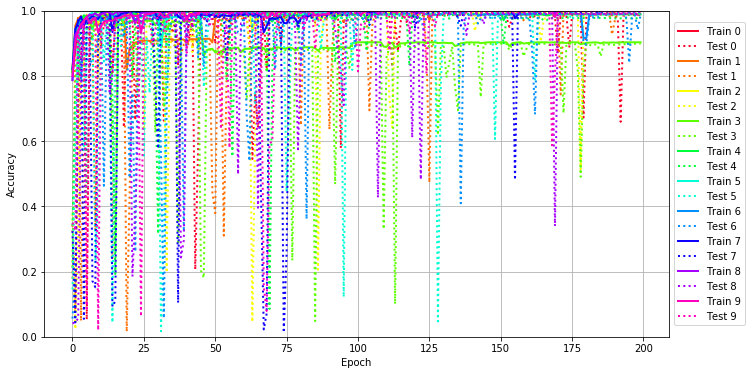

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

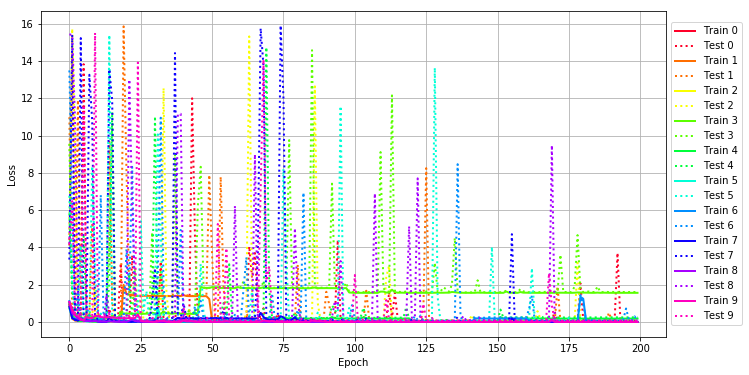

In [12]:
plot_loss(history)

Plotting the confusion matrix


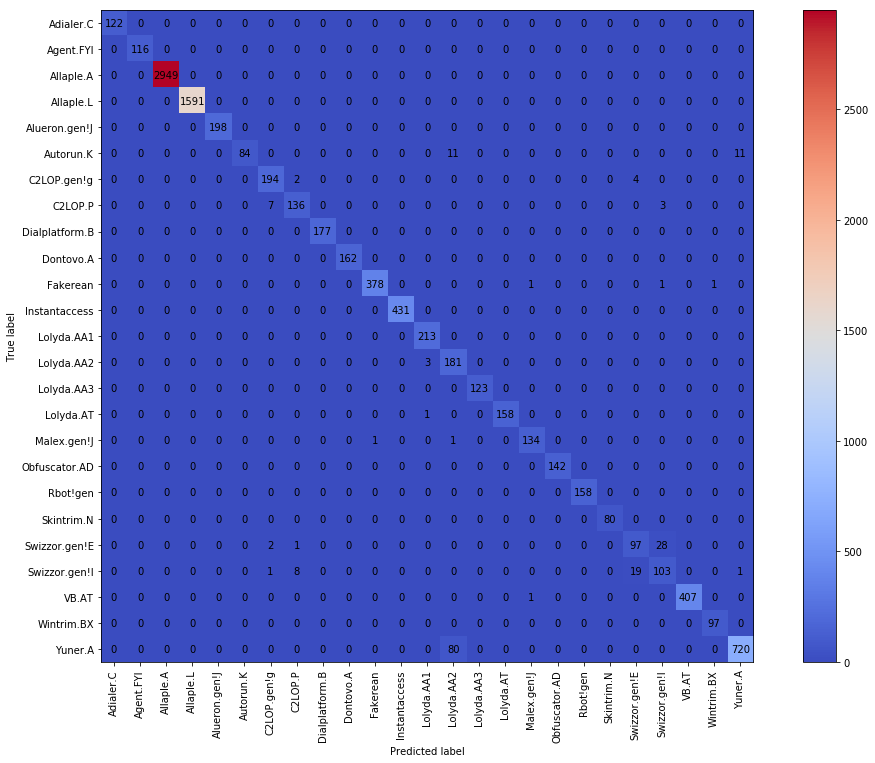

In [13]:
print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(18, 12)
plt.imshow(conf_mat,interpolation='nearest',cmap='coolwarm')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(int(conf_mat[row][col])),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


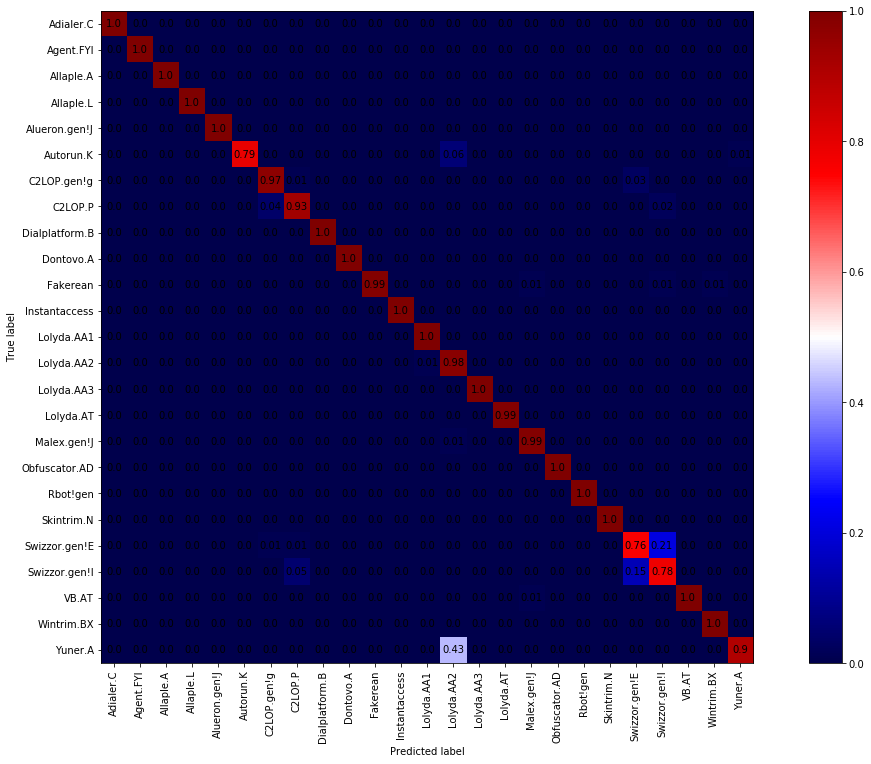

In [14]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='seismic')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat_norm[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


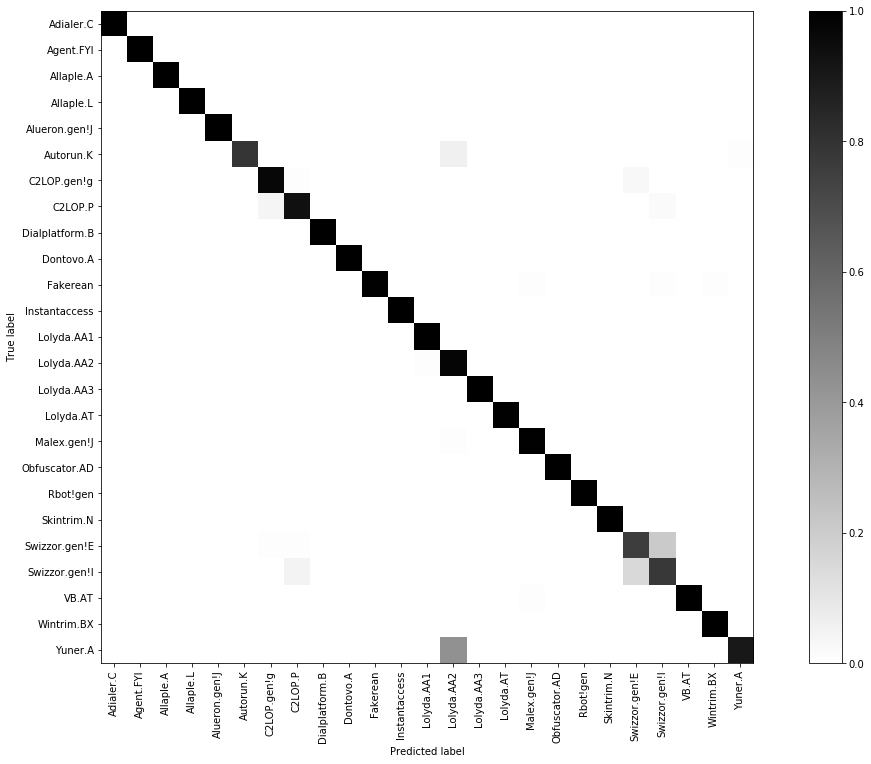

In [15]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='binary')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


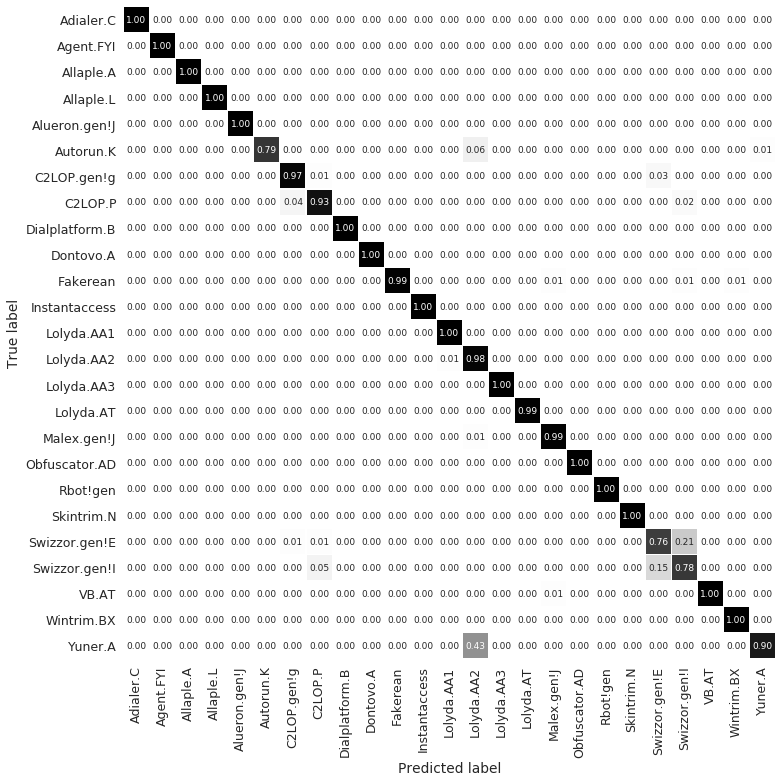

In [16]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()